# Proyecto final -EDA

<a id='seccion3'></a>
# 1 Importar librerías

In [6]:
# !pip install jupyter-collaboration

In [2]:
# Principales
import pandas as pd
import numpy as np

# Modificaciones 
import re
from unidecode import unidecode
import unicodedata
import datetime
import os
import math


#import matplotlib
# visuzalizaciones
import seaborn as sns
import missingno as msno
import matplotlib as plt 
import plotly.express as px 
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',80)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)
# Ajustar la configuración para mostrar más filas 
#pd.set_option('display.max_rows', 500)

#inicializo la lista to replace
to_replace=['Null','Nan','nan','NULL',None]


<a id='seccion3'></a>
# 2 Funciones

In [4]:
#Funcion que agrupa las columnas por tipo de dato

def columnas_por_tipo(df):
    # Filtrar columnas por tipo de datos
    int_columns = [col for col in df.columns if df[col].dtype.name.startswith('int')]
    float_columns = [col for col in df.columns if df[col].dtype.name.startswith('float')]
    boolean_columns=[col for col in df.columns if set(df[col].unique()) <= {0, 1}]
    numeric_cols=int_columns + float_columns 
    object_columns = df.select_dtypes(include='object').columns.tolist()
    category_columns = df.select_dtypes(include='category').columns.tolist()
     
    cat_columns=list(set(category_columns) - set(boolean_columns) )
    # Obtener todas las columnas 
    all_columns = set(df.columns) 
    # # Columnas de otros tipos 
    other_columns = list(all_columns - set(int_columns) - set(float_columns) - set(object_columns) - set(category_columns))

    # Cuento el número de columnas de cada tipo
    num_int_columns = len(int_columns)
    num_float_columns = len(float_columns)
    num_object_columns = len(object_columns)
    num_category_columns = len(category_columns)
    num_other_columns = len(other_columns)

    # Mostrar los resultados
    #print("Número de columnas de tipo entero:", num_int_columns)
    #print("Columnas de tipo entero:", int_columns)
    #print("Número de columnas de tipo float:", num_float_columns)
    #print("Columnas de tipo float:", float_columns)
    #print("Número de columnas de tipo object:", num_object_columns)
    #print("Columnas de tipo object:", object_columns)
    #print("Número de columnas de tipo category:", num_category_columns)
    #print("Columnas de tipo category:", category_columns)
    #print("Número de columnas de otros tipos:", num_other_columns)
    #print("Columnas de otros tipos:", other_columns)
    return boolean_columns,numeric_cols,cat_columns,object_columns,other_columns



In [5]:
def reduce_mem_usage(df, turn_cat=False, silence=True):
    """Itera sobre todo el dataset convirtiendo cada columna en el tipo más adecuado para ahorrar memoria
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe que se quiere reducir
    turn_cat : bool, optional
        Transformación de las columnas objeto o string a category, by default False
    Returns
    -------
    pd.DataFrame
        Dataframe optimizado
    """
  
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.api.types.is_numeric_dtype(df[col]):
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        if turn_cat and col_type == object:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if not silence:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:


def graficobarrascategoricas(df, colname):
    """Plots the barplot of a categorical variable with top 10 categories and groups the rest as 'Otros'. 

    Parameters:
    df (DataFrame): The DataFrame containing the data
    colname (str): Categorical variable's name

    Returns:
    None
    """ 
    # Obtener las frecuencias de las categorías
    value_counts = df[colname].value_counts()

    # Seleccionar las 10 categorías más frecuentes
    top_10 = value_counts.head(10)

    # Agrupar el resto en 'Otros'
    other_count = value_counts.tail(len(value_counts) - 10).sum()  # Sumar las frecuencias de las categorías restantes
    if other_count > 0:  # Solo agrupar si hay categorías para agrupar
        otros_series = pd.Series({'Otros': other_count})
        top_10 = pd.concat([top_10, otros_series])  # Usamos pd.concat() en lugar de append

    # Crear el gráfico de barras
    fig = plt.figure(figsize=(10, 6))
    fig.suptitle(f"Frecuencia de {colname}", fontsize=16)
    top_10.plot(kind='bar')

    # Mostrar el gráfico
    plt.xlabel(colname)
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)
    plt.show()


In [7]:
def plot_histogram_by_target(df, input_name, target_name, normalize = False):
    """Plots the histogram and boxplot of a numerical variable by target

    Parameters:
    input_name (str): Numeric variable's name
    target_name (str): Target variable's name

    Returns:
    None
    """
    fig = plt.figure(figsize=(15, 6))  # Ajustar el tamaño de la figura según sea necesario
    fig.suptitle(input_name, fontsize=16)

 
    ax1 = fig.add_subplot(121)
    sns.histplot(data=df, x=input_name, hue=target_name, alpha=.5, bins=25, ax=ax1, stat = 'density', common_norm = not normalize)
    
    ax2 = fig.add_subplot(122)
    sns.boxplot(data=df, x=target_name, y=input_name, ax=ax2)

    plt.tight_layout()
      # Asegurar que el título de la figura no se superponga
    plt.subplots_adjust(top=0.85)

In [8]:

def plot_barplot_by_target(df, input_name, target_name, stacked=False):
    """
    Grafica un gráfico de barras para una variable categórica en función de una variable objetivo.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con los datos.
    input_name : str
        Nombre de la columna categórica a analizar.
    target_name : str
        Nombre de la columna objetivo (target).
    stacked : bool, opcional, default=False
        Si se debe apilar el gráfico de barras.
    """
    # Crear una tabla de contingencia
    crosstab = pd.crosstab(df[input_name], df[target_name])
    
    # Crear un gráfico de barras apiladas usando Plotly
    fig = px.bar(crosstab, 
                 barmode='stack',  # Esto apila las barras
                # color=crosstab.columns,  # Colores por las columnas
                 title=f'Distribución de {input_name} por {target_name}')
    
    # Mostrar el gráfico
    fig.update_layout(xaxis_title=input_name, 
                      yaxis_title='Frecuencia', 
                      xaxis_tickangle=-45)
    
    fig.show()




<a id='seccion3'></a>
# 3 Leer el dataset

In [9]:
dfEDA= pd.read_csv('./data/pisosEDA.csv',index_col=False)

C:\Users\extas\AppData\Local\Temp\ipykernel_9448\2743511520.py:1: DtypeWarning:

Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.



In [10]:
print(f"El DataFrame dfEDA tiene {dfEDA.shape[0]} filas y {dfEDA.shape[1]} columnas.")

El DataFrame dfEDA tiene 10421 filas y 100 columnas.


In [11]:
dfEDA.columns


Index(['url', 'precio', 'descuento', 'm2_constr', 'cod_distrito', 'cod_barrio',
       'consumoce_ano', 'letrace', 'tipologia', 'estado', 'amueblado',
       'planta', 'dormitorios', 'banos', 'garaje', 'trastero', 'ascensor',
       'porteria', 'ano_construccion', 'jardin', 'cancha_tenis',
       'carpinteria_exterior_doble_vidrio/pvc',
       'carpinteria_exterior_doble_vidrio/madera',
       'carpinteria_exterior_doble_vidrio/metal',
       'carpinteria_exterior_triple_vidrio/madera',
       'carpinteria_exterior_triple_vidrio/metal',
       'carpinteria_exterior_vidrio/pvc', 'carpinteria_exterior_vidrio/madera',
       'carpinteria_exterior_vidrio/metal', 'chimenea', 'cocina', 'exterior',
       'interior', 'interior_y_exterior', 'tiene_piscina', 'porton_electrico',
       'puerta_blindada', 'alarma', 'videoportero', 'acceso_discapacidad',
       'certificado_energetico', 'tiene_jardin', 'cantidad_visitas',
       'cantidad_armarios', 'agua_caliente', 'tipo_suelo', 'm2_utiles',
    

In [12]:
dfEDA.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
url,10421,10421,https://www.indomio.es/anuncios/75404850/,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precio,10421.00,NaN,NaN,NaN,887678.02,1155675.73,25000.00,239900.00,480000.00,1090000.00,19950000.00
descuento,54.00,NaN,NaN,NaN,-7.79,2.99,-23.10,-9.00,-7.25,-5.75,-5.00
m2_constr,10394.00,NaN,NaN,NaN,137.21,148.68,0.00,68.00,98.00,149.00,4574.00
cod_distrito,10421.00,NaN,NaN,NaN,7.91,5.76,1.00,4.00,7.00,12.00,21.00
...,...,...,...,...,...,...,...,...,...,...,...
hog_con_11,10421.00,NaN,NaN,NaN,27.38,17.42,3.00,10.00,26.00,36.00,64.00
hog_con_12,10421.00,NaN,NaN,NaN,17.16,11.67,0.00,8.00,14.00,21.00,50.00
hog_con_13,10421.00,NaN,NaN,NaN,9.29,5.23,0.00,4.00,9.00,11.00,22.00
hog_con_14,10421.00,NaN,NaN,NaN,36.96,13.59,7.00,28.00,39.00,48.00,59.00


In [13]:
#Trato las columnas para quitar espacios si tuvieran y pongo el nombre de las columnas en minisculas 
# para tener desde el primer momento siempre el mismo nombre de columnas
dfEDA.columns = [col.strip().lower() for col in dfEDA.columns]

In [14]:
dfEDA.columns.tolist()

['url',
 'precio',
 'descuento',
 'm2_constr',
 'cod_distrito',
 'cod_barrio',
 'consumoce_ano',
 'letrace',
 'tipologia',
 'estado',
 'amueblado',
 'planta',
 'dormitorios',
 'banos',
 'garaje',
 'trastero',
 'ascensor',
 'porteria',
 'ano_construccion',
 'jardin',
 'cancha_tenis',
 'carpinteria_exterior_doble_vidrio/pvc',
 'carpinteria_exterior_doble_vidrio/madera',
 'carpinteria_exterior_doble_vidrio/metal',
 'carpinteria_exterior_triple_vidrio/madera',
 'carpinteria_exterior_triple_vidrio/metal',
 'carpinteria_exterior_vidrio/pvc',
 'carpinteria_exterior_vidrio/madera',
 'carpinteria_exterior_vidrio/metal',
 'chimenea',
 'cocina',
 'exterior',
 'interior',
 'interior_y_exterior',
 'tiene_piscina',
 'porton_electrico',
 'puerta_blindada',
 'alarma',
 'videoportero',
 'acceso_discapacidad',
 'certificado_energetico',
 'tiene_jardin',
 'cantidad_visitas',
 'cantidad_armarios',
 'agua_caliente',
 'tipo_suelo',
 'm2_utiles',
 'gastos_comunidad',
 'zonas_verdes',
 'puerta_seguridad',
 't

In [15]:
pd.set_option('display.max_info_columns',110 )



In [16]:
dfEDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10421 entries, 0 to 10420
Data columns (total 100 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   url                                               10421 non-null  object 
 1   precio                                            10421 non-null  float64
 2   descuento                                         54 non-null     float64
 3   m2_constr                                         10394 non-null  float64
 4   cod_distrito                                      10421 non-null  float64
 5   cod_barrio                                        10184 non-null  float64
 6   consumoce_ano                                     501 non-null    object 
 7   letrace                                           1388 non-null   object 
 8   tipologia                                         10421 non-null  object 
 9   estado          

<a id='seccion3'></a>
# 4 Exploración de datos

In [17]:
# Distribución de la variable target en porcentaje
dfEDA["precio"].value_counts(normalize = True) 

precio
650000.00    0.01
220000.00    0.01
230000.00    0.01
260000.00    0.01
350000.00    0.01
             ... 
812000.00    0.00
237700.00    0.00
327000.00    0.00
206500.00    0.00
1355000.00   0.00
Name: proportion, Length: 1641, dtype: float64

In [18]:
dfEDA.precio.describe(percentiles=[0.15,0.3,0.45,0.55,0.75,0.9])

count      10421.00
mean      887678.02
std      1155675.73
min        25000.00
15%       185000.00
30%       269000.00
45%       400000.00
50%       480000.00
55%       580000.00
75%      1090000.00
90%      1990000.00
max     19950000.00
Name: precio, dtype: float64

In [19]:
dfEDA.drop_duplicates(keep='first', inplace=True)

In [20]:
# Compruebo que url es unico
dfEDA['url'].nunique() == len(dfEDA)

True

In [21]:
dfEDA["precio"].describe()

count      10421.00
mean      887678.02
std      1155675.73
min        25000.00
25%       239900.00
50%       480000.00
75%      1090000.00
max     19950000.00
Name: precio, dtype: float64

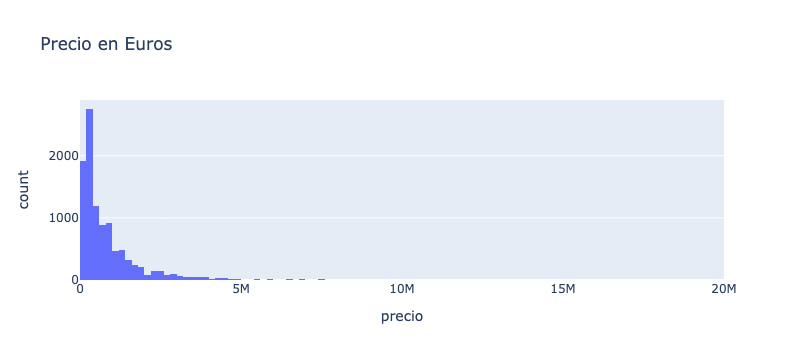

In [22]:
##HISTOGRAMA
fig = px.histogram(dfEDA,x="precio", nbins=100,title='Precio en Euros', labels={'value': 'Precio'})
fig.show()

In [23]:
#llamo a la funcion columnas_por_tipo que muestra un resumen de los tipo de columnas que tengo en el dataframe
#boolean_columns,numeric_cols,cat_columns,object_columns,other_columns
cols_bool,cols_num,cols_cat,cols_obj,cols_other=columnas_por_tipo(dfEDA)
print("Booleans:", cols_bool)
print("Numéricas:", cols_num)
print("Categoricas:", cols_cat)
print("Objeto:", cols_obj)
print("Otras:", cols_other)

Booleans: ['orientacion_este', 'orientacion_norte', 'orientacion_oeste', 'orientacion_sur']
Numéricas: ['precio', 'descuento', 'm2_constr', 'cod_distrito', 'cod_barrio', 'dormitorios', 'trastero', 'cancha_tenis', 'carpinteria_exterior_doble_vidrio/pvc', 'carpinteria_exterior_doble_vidrio/madera', 'carpinteria_exterior_doble_vidrio/metal', 'carpinteria_exterior_triple_vidrio/madera', 'carpinteria_exterior_triple_vidrio/metal', 'carpinteria_exterior_vidrio/pvc', 'carpinteria_exterior_vidrio/madera', 'carpinteria_exterior_vidrio/metal', 'chimenea', 'exterior', 'interior', 'interior_y_exterior', 'tiene_piscina', 'porton_electrico', 'puerta_blindada', 'alarma', 'videoportero', 'acceso_discapacidad', 'tiene_jardin', 'cantidad_visitas', 'cantidad_armarios', 'm2_utiles', 'zonas_verdes', 'puerta_seguridad', 'orientacion_este', 'orientacion_norte', 'orientacion_oeste', 'orientacion_sur', 'sistema_alarma', 'emisiones_ano', 'codigo_postal', 'num_personas', 'num_personas_hombres', 'num_personas_muj

<a id='seccion3'></a>
# 5 Analisis estadistico inicial

### 5.1 Univariante

#### 5.1.1 Variables numéricas

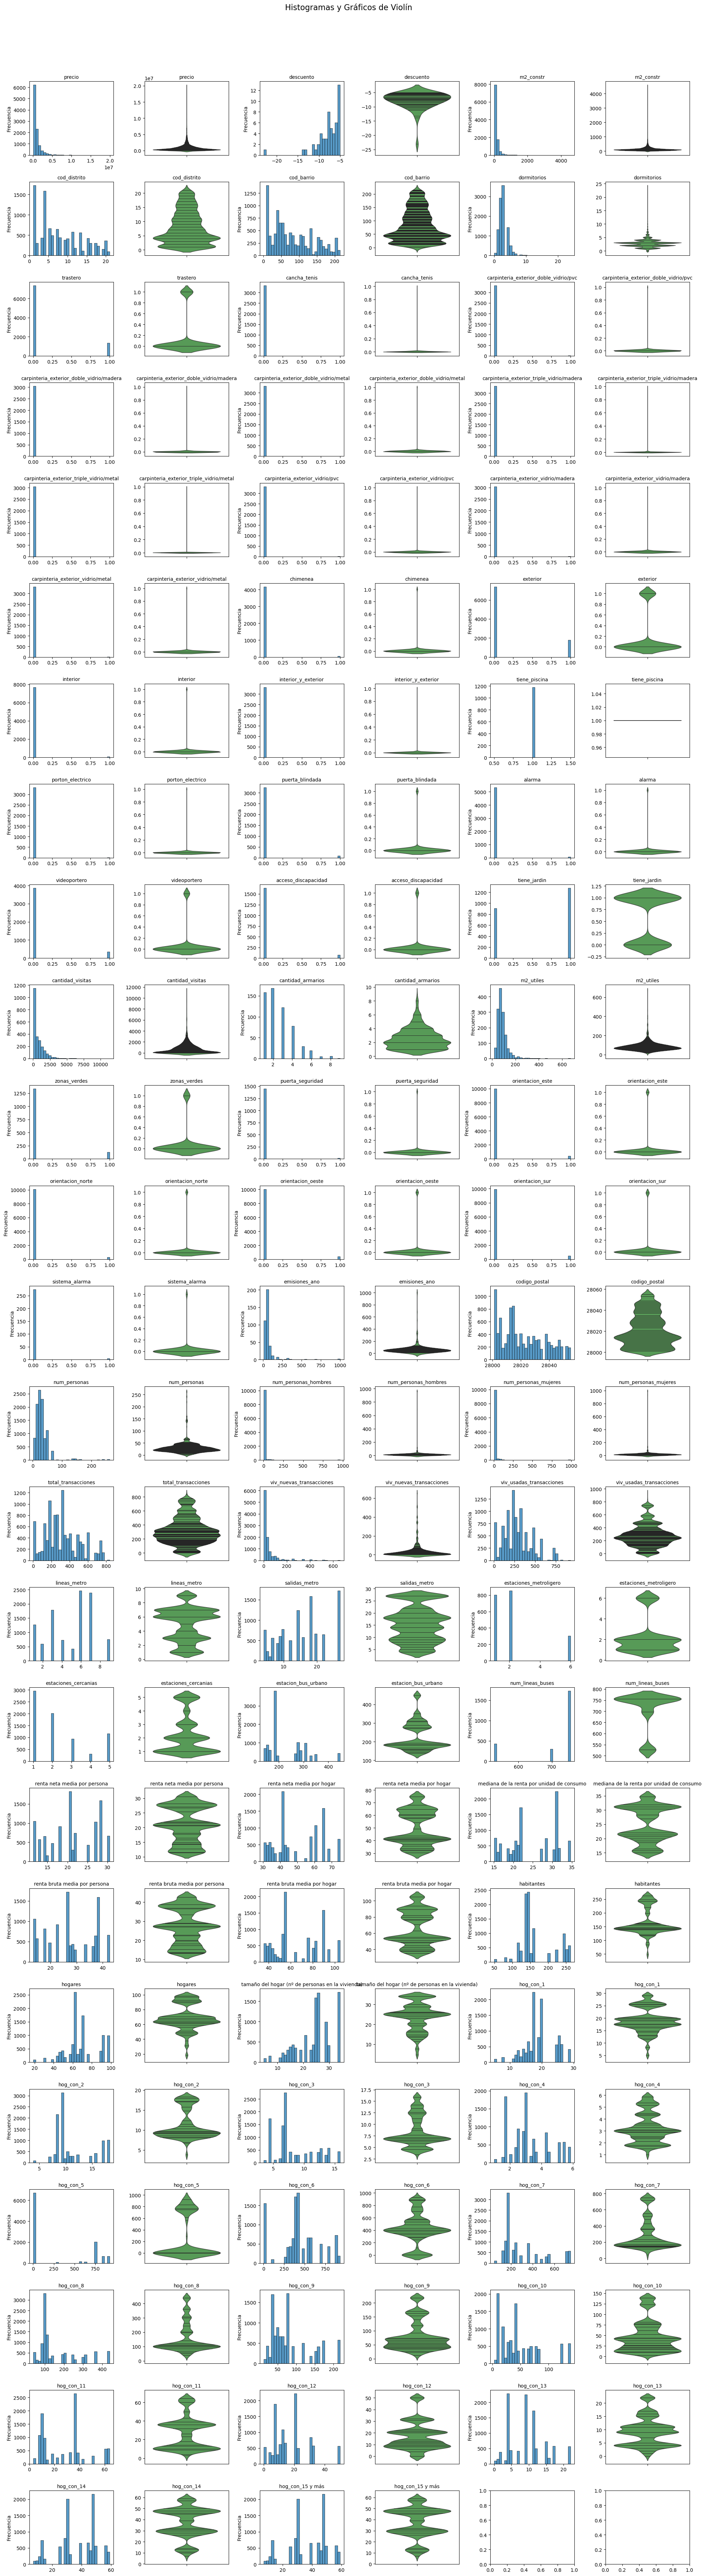

In [24]:
#Grafico con histogramas y violin para las variables categoricas

# Parámetros 
var_porfila = 3  # Número de variables por fila
graf_porvariable = 2  # Histograma y violín
tot_var = len(cols_num)

# Calcular el número de filas y columnas
n_cols = var_porfila * graf_porvariable  # Total de columnas por fila
n_rows = math.ceil(tot_var / var_porfila)  # Número de filas necesarias

# Crear subplots dinámicamente
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 3 * n_rows))
fig.suptitle('Histogramas y Gráficos de Violín', fontsize=16)

if n_rows == 1:
    axes = axes.reshape(1, -1)  # Convierte a 2D si hay solo una fila

# Añadir gráficos
for i, col in enumerate(cols_num):
    row = i // var_porfila  # Fila correspondiente
    col_hist = (i % var_porfila) * graf_porvariable  # Columna del histograma
    col_violin = col_hist + 1  # Columna del gráfico de violín

    # Histograma
    sns.histplot(dfEDA[col].dropna(), bins=30, ax=axes[row, col_hist])
    axes[row, col_hist].set_title(f'{col}', fontsize=10)
    axes[row, col_hist].set_xlabel("")
    axes[row, col_hist].set_ylabel("Frecuencia")

    # Gráfico de violín

    sns.violinplot(y=dfEDA[col].dropna(), ax=axes[row, col_violin], inner="stick", color='green', alpha=0.7)

    axes[row, col_violin].set_title(f'{col}', fontsize=10)
    axes[row, col_violin].set_ylabel("")
    axes[row, col_violin].set_xlabel("")



# Ajustar el diseño
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#####Explicacion graficos

#### 5.1.2 Variables categoricas

In [26]:
#grafico de barras de variables categoricas
for col in cols_cat:
    graficobarrascategoricas(dfEDA,colname=col)

### 5.2 Bivariante

#### 5.2.1 Variables numéricas

In [ ]:
#Selecciono un subconjunto de variables numericas para hacer el estudio
cols= ['m2_constr', 'cod_barrio','cod_distrito']
for c in cols:
    plot_histogram_by_target(df = dfEDA.sort_values("precio"), input_name = c, target_name = 'precio', normalize = True)

C:\Users\extas\AppData\Local\Temp\ipykernel_9448\2741493430.py:21: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\extas\AppData\Local\Temp\ipykernel_9448\2741493430.py:21: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.

C:\Users\extas\AppData\Local\Temp\ipykernel_9448\2741493430.py:21: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

C:\Users\extas\AppData\Local\Temp\ipykernel_9448\2741493430.py:21: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



KeyboardInterrupt: 

#### 5.2.2 Variables categóricas

In [ ]:

# Asumiendo que tienes el dataframe dfMMP y las variables categóricas
for c in cols_cat:
        plot_barplot_by_target(df=dfEDA, input_name=c, target_name='precio', stacked=True)

<a id='seccion3'></a>
# 6 Limpieza de datos

### 6.1 Eliminación de duplicados

In [ ]:
# Comprobamos si hay filas duplicadas 
len(dfEDA.drop_duplicates()) / len(dfEDA) 

### 6.2 Tratamiento de nulos

In [ ]:
for col in dfEDA.columns:
    porcentaje_nulos = dfEDA[col].isnull().mean() * 100
    if porcentaje_nulos > 65:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')


In [ ]:
#oompruebamos si hay columnas con un 95% de los datos iguales, eliminaré estas columnas
[col for col in dfEDA.columns if dfEDA[col].value_counts(normalize=True).max() >= 0.95]

# NOTA: REVISAR SI VAMOS A ELIMINAR CON ESTOS UMBRLES, DE MOMENTO LO COMENTO

In [ ]:
#######

#Eliminamos LAS COLUMNAS con un porcentaje de nulos mayor del 65 % y las columnas desequilibradas en las que una categoría contiene el 95% o mas de los datos.
#umbral = len(dfEDA) * 0.35 
# Eliminar columnas con más del 90% de valores nulos 
#dfEDA=dfEDA.dropna(axis=1, thresh=umbral)
#dfEDA=dfEDA.drop(columns=[col for col in dfEDA.columns if dfEDA[col].value_counts(normalize=True).max() >= 0.95])
#dfEDA.shape

In [ ]:
#compruebo que columnas tenen nulos
for col in dfMMP.columns:
    porcentaje_nulos = dfMMP[col].isnull().mean() * 100
    if porcentaje_nulos > 0:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

### 6.2.1 Imputacion de nulos variables númericas

### 6.2.2 Imputación de nulos variables categoricas

<a id='seccion3'></a>

# 7 Feature engineering y Categorical Encoding

## <a id='seccion3'></a>
# 8  Analisis Estadistico Final

## <a id='seccion3'></a>
# 9  Dataset para generacion de modelo